In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#dbscan, dbscan, hierarchical (sklearn)
from sklearn.cluster import dbscan, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [4]:
df = pd.read_csv("../../our_analyses/dataset_prepared.csv")

In [5]:
df['explicit'] = df['explicit'].apply(lambda x: 1 if x else 0)
df['genre'] = pd.factorize(df['genre'])[0]
y = np.array(df["genre"])
df = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
X = df.values

In [6]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_minmax)

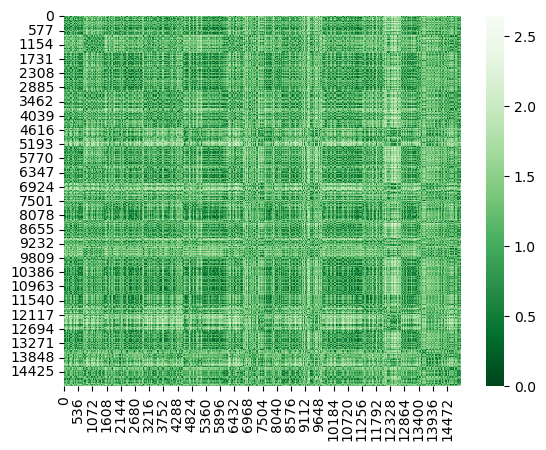

In [7]:
dist = pdist(X_pca, 'euclidean')
dist = squareform(dist)

sns.heatmap(dist, cmap="Greens_r", annot=False)
plt.show()

In [8]:
k=4
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

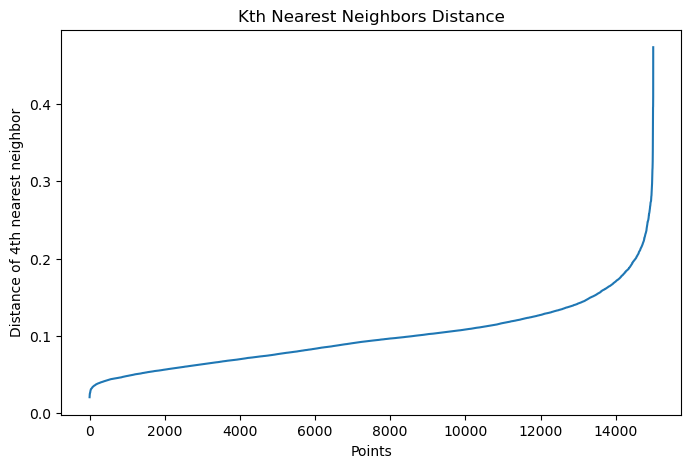

In [29]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(0, len(kth_distances)), y=sorted(kth_distances))
plt.title('Kth Nearest Neighbors Distance')
plt.xlabel('Points')
plt.ylabel(f'Distance of {k}th nearest neighbor')
plt.show()

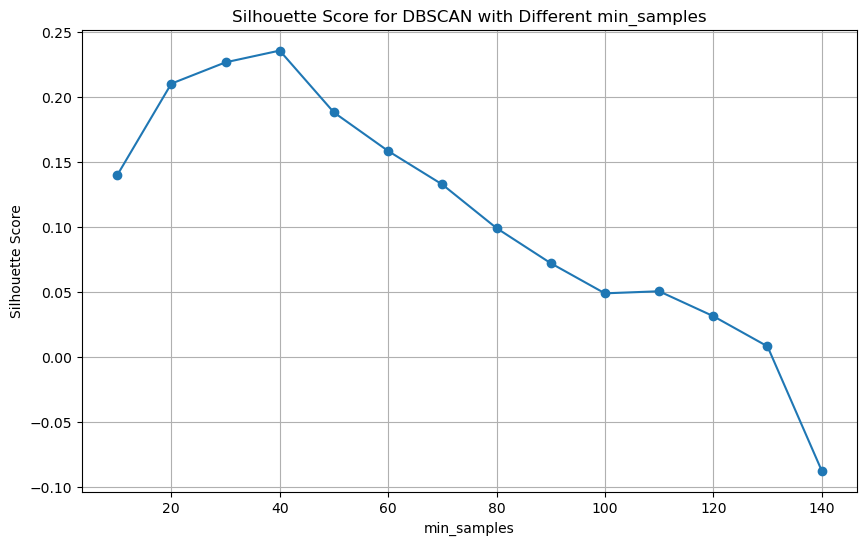

In [21]:
# List to store the silhouette scores for different min_samples values
silhouette_scores = []
min_samples_list = range(10, 150, 10)  # min_samples values from 10 to 60

# Experiment with an `eps` value within the estimated range before the sharp increase
eps_value = 0.2 # for example, you can start with this and adjust based on the results

# Calculate silhouette score for different values of min_samples
for min_samples in min_samples_list:
    # Initialize DBSCAN with the current min_samples and estimated eps
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
    # Fit the model
    clusters = dbscan.fit_predict(X_pca)
    
    # Silhouette score can only be computed if there are 2 or more clusters (excluding noise)
    if len(set(clusters)) - (1 if -1 in clusters else 0) > 1:
        score = silhouette_score(X_pca, clusters)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(None)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(min_samples_list, silhouette_scores, marker='o')
plt.title('Silhouette Score for DBSCAN with Different min_samples')
plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [45]:
dbscan = DBSCAN(eps=0.19, min_samples=35)
dbscan.fit(X_pca)

print('Silhouette', silhouette_score(X_pca, dbscan.labels_))

Silhouette 0.249953055286065


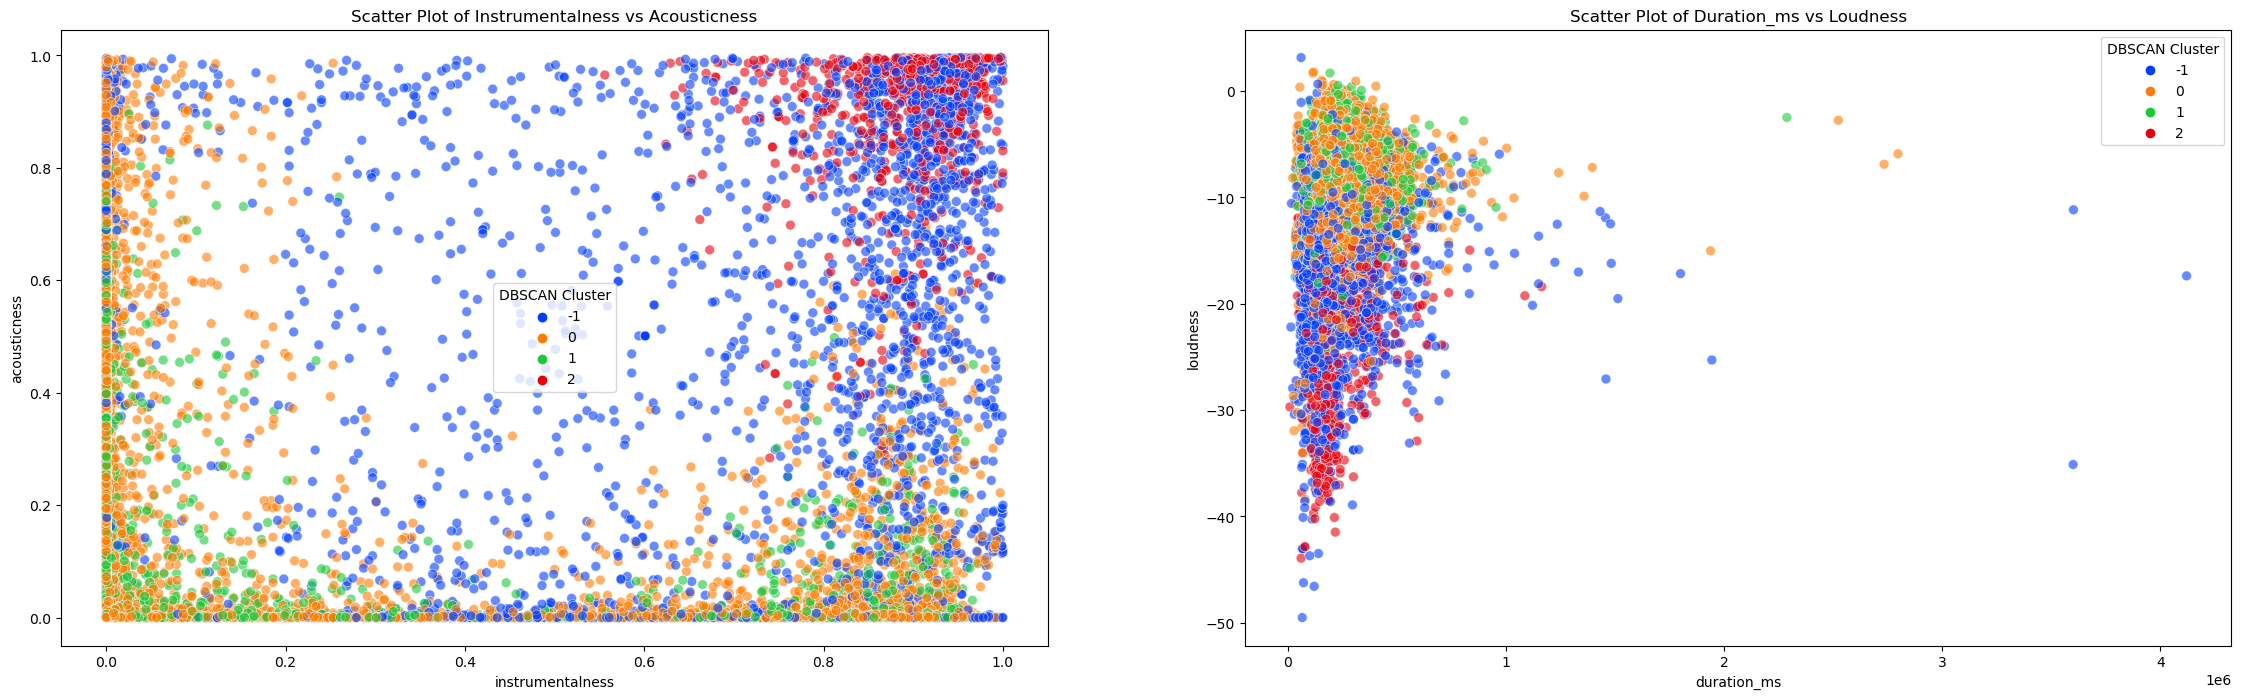

Unique DBSCAN labels (clusters): [-1  0  1  2]
Counts of points in each cluster: [2777 8315 3269  639]


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df is your dataframe and it already includes 'instrumentalness', 'acousticness', 'duration_ms', and 'loudness' columns

# Assign DBSCAN labels to the dataframe
df['dbscan_labels'] = dbscan.labels_

# Find unique clusters and their counts to determine centroids
unique_dbscan_labels, counts_dbscan_labels = np.unique(dbscan.labels_, return_counts=True)

# Create a subplot layout for the scatter plots
plt.figure(figsize=(28, 8))

# Scatter plot for instrumentalness vs acousticness
plt.subplot(1, 2, 1)
scatter_plot_instrumentalness = sns.scatterplot(data=df, 
                                                x="instrumentalness",
                                                y="acousticness", 
                                                hue='dbscan_labels', 
                                                palette="bright",
                                                alpha=0.6,  # Set transparency
                                                s=50)  # Point size
plt.legend(title='DBSCAN Cluster')
plt.title('Scatter Plot of Instrumentalness vs Acousticness')

# Scatter plot for duration_ms vs loudness
plt.subplot(1, 2, 2)
scatter_plot_duration = sns.scatterplot(data=df, 
                                        x="duration_ms",
                                        y="loudness", 
                                        hue='dbscan_labels', 
                                        palette="bright",
                                        alpha=0.6,  # Set transparency
                                        s=50)  # Point size
plt.legend(title='DBSCAN Cluster')
plt.title('Scatter Plot of Duration_ms vs Loudness')

# Show the plot
plt.show()

# Print the unique clusters and their counts
print("Unique DBSCAN labels (clusters):", unique_dbscan_labels)
print("Counts of points in each cluster:", counts_dbscan_labels)


In [36]:
import pandas as pd
from sklearn.cluster import KMeans

# Assumiamo che X_minmax e y siano già definiti e che y contenga i generi musicali

# Eseguire KMeans

# Assegnare ogni punto ai suoi rispettivi cluster
cluster_labels = dbscan.labels_

# Creare una nuova colonna nel DataFrame originale per i cluster
df['cluster'] = cluster_labels

# Recuperare la colonna 'genre' che era stata trasformata in y
df['genre'] = y

# Calcolare la frequenza di ogni genere in ciascun cluster
cluster_genre_counts = df.groupby(['cluster', 'genre']).size().unstack(fill_value=0)

# Calcolare la dimensione di ogni cluster
cluster_sizes = df['cluster'].value_counts()

# Calcolare le proporzioni relative di ogni genere all'interno dei cluster
cluster_genre_proportions = cluster_genre_counts.div(cluster_sizes, axis=0)

# Determinare il cluster dominante per ogni genere basandosi sulle proporzioni
dominant_cluster_per_genre = cluster_genre_proportions.idxmax(axis=0)

print(dominant_cluster_per_genre)


genre
0     1
1    -1
2     0
3     0
4     1
5     1
6     2
7     1
8     1
9     2
10    0
11    1
12    2
13    1
14    0
15    0
16    2
17    1
18   -1
19    1
dtype: int64


In [53]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

optics = OPTICS(min_samples = 25, max_eps = 0.5)
optics.fit(X_pca)

OPTICS(max_eps=0.5, min_samples=25)

In [54]:
print("Silhouette", silhouette_score(X_pca[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])) #exlude noise, tipycal error

Silhouette 0.3329924533762924


In [52]:
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
import numpy as np

# Imposta una griglia di parametri basata sull'interpretazione del reachability plot
param_grid = {
    'min_samples': [20, 25, 30, 35],  # Valori intorno al tuo min_samples attuale, adattati in base al grafico
    'max_eps': [0.2, 0.3, 0.4, 0.5]   # Gamma di max_eps scelta per essere al di sotto dei picchi principali
}

# Prepara i risultati
results = []

# Esegui la ricerca su griglia
for min_samples in param_grid['min_samples']:
    for max_eps in param_grid['max_eps']:
        # Adatta il modello OPTICS con i parametri correnti
        optics = OPTICS(min_samples=min_samples, max_eps=max_eps)
        optics.fit(X_pca)

        # Ignora il cluster di rumore (-1) quando calcoli la silhouette score
        labels = optics.labels_
        if len(set(labels)) > 1:  # Assicurati che ci siano cluster al di là del rumore
            score = silhouette_score(X_pca, labels)
            results.append((min_samples, max_eps, score))

# Ordina i risultati per la migliore silhouette score
results.sort(key=lambda x: x[2], reverse=True)

# Stampa i migliori parametri
print(f"Best parameters based on silhouette score: min_samples = {results[0][0]}, max_eps = {results[0][1]} with a silhouette score of {results[0][2]}")


Best parameters based on silhouette score: min_samples = 25, max_eps = 0.5 with a silhouette score of 0.3329924533762924


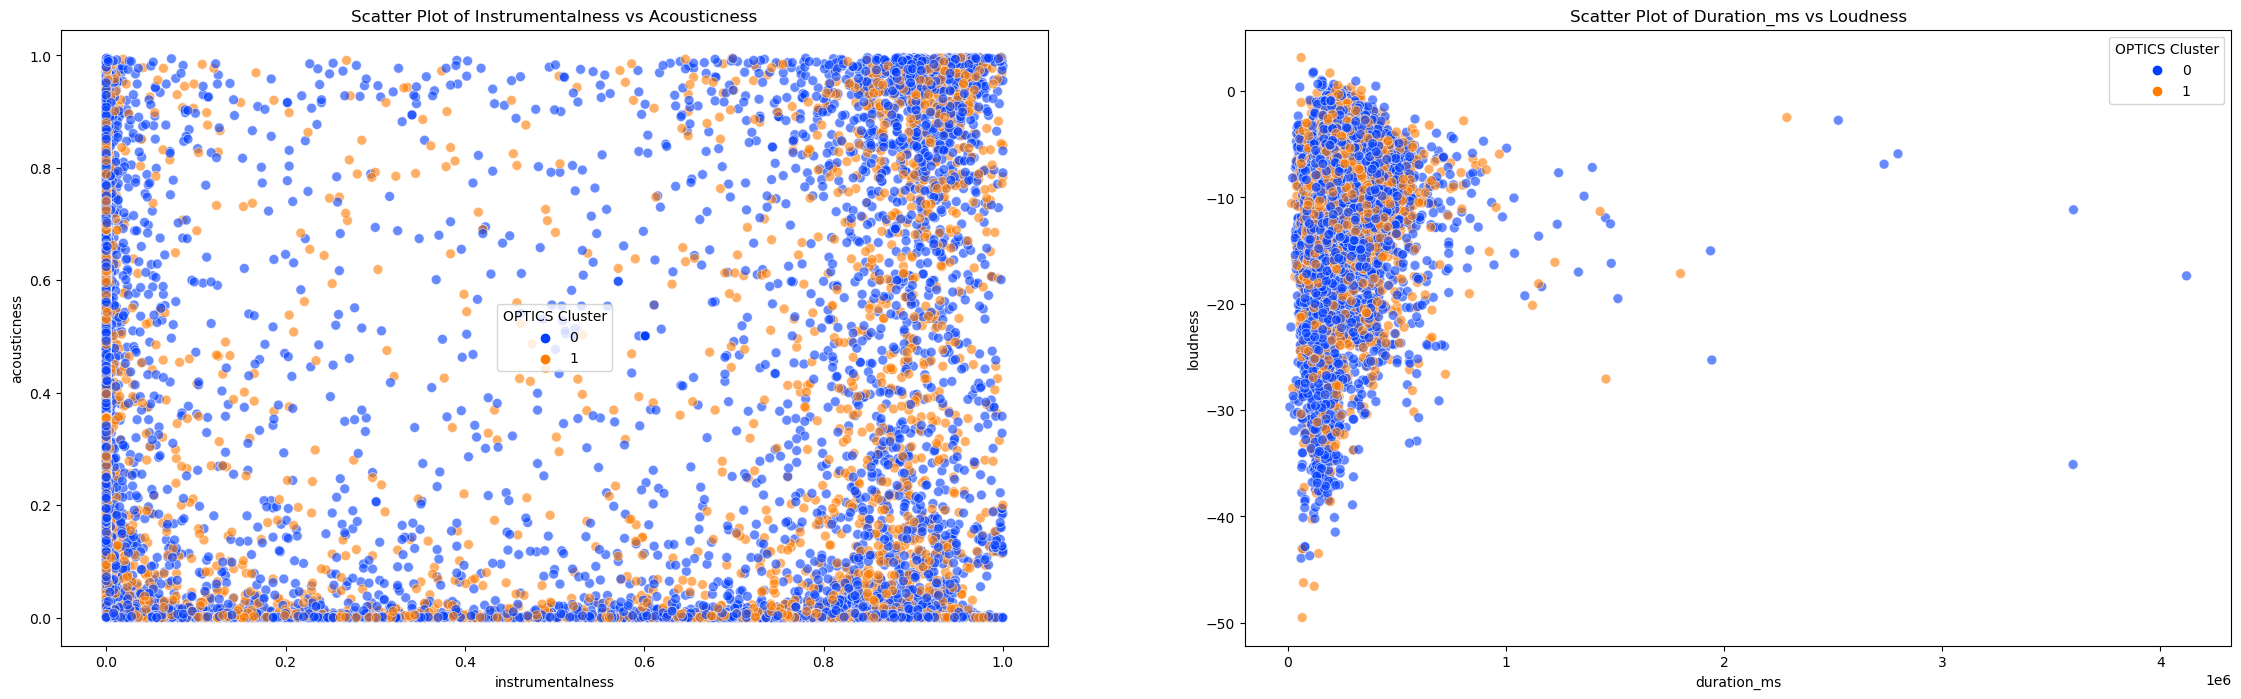

Unique DBSCAN labels (clusters): [0 1]
Counts of points in each cluster: [10158  4842]


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df is your dataframe and it already includes 'instrumentalness', 'acousticness', 'duration_ms', and 'loudness' columns

# Assign DBSCAN labels to the dataframe
df['optics_labels'] = optics.labels_

# Find unique clusters and their counts to determine centroids
unique_dbscan_labels, counts_dbscan_labels = np.unique(optics.labels_, return_counts=True)

# Create a subplot layout for the scatter plots
plt.figure(figsize=(28, 8))

# Scatter plot for instrumentalness vs acousticness
plt.subplot(1, 2, 1)
scatter_plot_instrumentalness = sns.scatterplot(data=df, 
                                                x="instrumentalness",
                                                y="acousticness", 
                                                hue='optics_labels', 
                                                palette="bright",
                                                alpha=0.6,  # Set transparency
                                                s=50)  # Point size
plt.legend(title='OPTICS Cluster')
plt.title('Scatter Plot of Instrumentalness vs Acousticness')

# Scatter plot for duration_ms vs loudness
plt.subplot(1, 2, 2)
scatter_plot_duration = sns.scatterplot(data=df, 
                                        x="duration_ms",
                                        y="loudness", 
                                        hue='optics_labels', 
                                        palette="bright",
                                        alpha=0.6,  # Set transparency
                                        s=50)  # Point size
plt.legend(title='OPTICS Cluster')
plt.title('Scatter Plot of Duration_ms vs Loudness')

# Show the plot
plt.show()

# Print the unique clusters and their counts
print("Unique DBSCAN labels (clusters):", unique_dbscan_labels)
print("Counts of points in each cluster:", counts_dbscan_labels)


In [43]:
import pandas as pd
from sklearn.cluster import KMeans

# Assumiamo che X_minmax e y siano già definiti e che y contenga i generi musicali

# Eseguire KMeans

# Assegnare ogni punto ai suoi rispettivi cluster
cluster_labels = optics.labels_

# Creare una nuova colonna nel DataFrame originale per i cluster
df['cluster'] = cluster_labels

# Recuperare la colonna 'genre' che era stata trasformata in y
df['genre'] = y

# Calcolare la frequenza di ogni genere in ciascun cluster
cluster_genre_counts = df.groupby(['cluster', 'genre']).size().unstack(fill_value=0)

# Calcolare la dimensione di ogni cluster
cluster_sizes = df['cluster'].value_counts()

# Calcolare le proporzioni relative di ogni genere all'interno dei cluster
cluster_genre_proportions = cluster_genre_counts.div(cluster_sizes, axis=0)

# Determinare il cluster dominante per ogni genere basandosi sulle proporzioni
dominant_cluster_per_genre = cluster_genre_proportions.idxmax(axis=0)

print(dominant_cluster_per_genre)


genre
0    -1
1     3
2    -1
3     2
4     1
5     3
6     2
7    -1
8     1
9     3
10    2
11    3
12    2
13    0
14    0
15    2
16   -1
17    1
18   -1
19    3
dtype: int64
